# Chat Agent Executer

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import paginx

os.environ["LANGCHAIN_TRACING_V2"] = "true"

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Set up the tools

We will first define the tools we want to use. For this simple example, we will use create a placeholder search engine. However, it is really easy to create your own tools - see documentation here on how to do that.

In [2]:
from langchain.tools.retriever import create_retriever_tool
from langchain.tools.tavily_search import TavilySearchResults

from langchain_cohere import CohereEmbeddings


chroma = paginx.Chroma(CohereEmbeddings())
vectorstore = chroma.load_db('../tmp_files')

retriever = vectorstore.as_retriever()

web_search_tool = TavilySearchResults(k=3)
web_search_tool.invoke("Whats the current weather in Antwerp")

[{'url': 'https://www.accuweather.com/en/be/antwerp/27046/weather-forecast/27046',
  'content': 'Current Weather. 1:27 AM. 59° F. RealFeel® 52°. Cloudy More Details. Wind SSW 8 mph. Wind Gusts 10 mph. Air Quality Fair.'},
 {'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Antwerp', 'region': '', 'country': 'Belgium', 'lat': 51.22, 'lon': 4.42, 'tz_id': 'Europe/Brussels', 'localtime_epoch': 1720871077, 'localtime': '2024-07-13 13:44'}, 'current': {'last_updated_epoch': 1720870200, 'last_updated': '2024-07-13 13:30', 'temp_c': 16.3, 'temp_f': 61.3, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 13.6, 'wind_kph': 22.0, 'wind_degree': 230, 'wind_dir': 'SW', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.2, 'precip_in': 0.01, 'humidity': 72, 'cloud': 75, 'feelslike_c': 16.3, 'feelslike_f': 61.3, 'windchill_c': 16.5, 'windchill_f': 61.6, 'heatindex_c': 16.5, 'heati

In [3]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, streaming=True)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents about the AI-startup named Vectrix.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"}
    )
)
print(question_router.invoke({"question": "Who are the founders of Vectrix ?"}))

datasource='web_search'
datasource='vectorstore'


In [4]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "Vectrix founders"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [5]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The founders of Vectrix are Ben Selleslagh and Dimitri Allaert. Ben has a background in data from banking, government, and media sectors, while Dimitri has roots in medical engineering and the pharmaceutical world. They both contribute their expertise to drive AI solutions at Vectrix.


In [6]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [7]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [8]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Who are the founders of Vectrix?'

## Create the Graph
### Graph State

In [9]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    transform_query_count: int

### Graph Flow

In [10]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    transform_query_count = state["transform_query_count"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "transform_query_count": transform_query_count}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    transform_query_count = state["transform_query_count"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "transform_query_count": transform_query_count}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    transform_query_count = state["transform_query_count"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question, "transform_query_count": transform_query_count}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    if state['transform_query_count']:
        transform_query_count = state['transform_query_count']
        transform_query_count += 1
    else:
        transform_query_count = 1

    print(f"Transform query count: {transform_query_count}")

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question, "transform_query_count": transform_query_count}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if state['transform_query_count']:
        if state['transform_query_count'] > 2:
            print("---DECISION: TRANSFORM QUERY COUNT EXCEEDED---")
            return "generate"

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )

        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    if state['transform_query_count']:
        if state['transform_query_count'] > 2:
            print("---DECISION: TRANSFORM QUERY COUNT EXCEEDED---")
            return "useful"

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [11]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint import MemorySaver


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Compile
app = workflow.compile()

In [12]:
from pprint import pprint

# Run
inputs = {
    "question": "Who are the founders of Vectrix  ? "
}
for output in app.stream(inputs, config={"configurable": {"thread_id": 77}}):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The founders of Vectrix are Ben Selleslagh and Dimitri Allaert. Ben '
 'Selleslagh has a background in data from banking, government, and media '
 'sectors, while Dimitri Allaert has roots in medical engineering and the '
 'pharmaceutical world. They both contribute their expertise to drive data and '
 'AI solutions at Vectrix.')


In [13]:
from pprint import pprint

# Run
inputs = {
    "question": "How tall is the Eiffel Tower ?"
}
for output in app.stream(inputs, config={"configurable": {"thread_id": 77}}):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Eiffel Tower is 300 meters tall, with antennas that bring the total '
 'height to 324 meters. It was the tallest structure in France until the '
 'completion of the Millau Viaduct in 2004. The tower was the tallest '
 'structure in the world until the Chrysler Building in New York City was '
 'completed in 1930.')


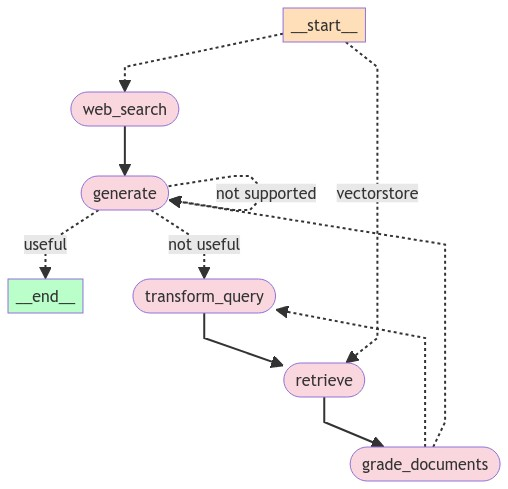

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Streaming Example

In [15]:
inputs = {
    "question": "Who are the founders of Vectrix  ? "
}

async for output in app.astream_log(inputs, include_types=["llm"]):
    # astream_log() yields the requested logs (here LLMs) in JSONPatch format
    for op in output.ops:
        if op["path"] == "/streamed_output/-":
            # this is the output from .stream()
            ...
        elif op["path"].startswith("/logs/") and op["path"].endswith(
            "/streamed_output/-"
        ):
            # because we chose to only include LLMs, these are LLM tokens
            print(op["value"])

---ROUTE QUESTION---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_80YmLdSrshCuybMtJaiF5v7D', 'function': {'arguments': '', 'name': 'RouteQuery'}, 'type': 'function'}]} id='run-e6cf1b5d-4b56-4d27-8778-0b330c874724' tool_calls=[{'name': 'RouteQuery', 'args': {}, 'id': 'call_80YmLdSrshCuybMtJaiF5v7D'}] tool_call_chunks=[{'name': 'RouteQuery', 'args': '', 'id': 'call_80YmLdSrshCuybMtJaiF5v7D', 'index': 0}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': '{"', 'name': None}, 'type': None}]} id='run-e6cf1b5d-4b56-4d27-8778-0b330c874724' tool_calls=[{'name': '', 'args': {}, 'id': None}] tool_call_chunks=[{'name': None, 'args': '{"', 'id': None, 'index': 0}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': 'datas', 'name': None}, 'type': None}]} id='run-e6cf1b5d-4b56-4d27-8778-0b330c874724' invalid_tool_calls=[{'name': None, 'args': 'datas', 'id': None, 'error': None}] tool_c

In [16]:
app.invoke({
    "question": "Where is Vectrix located ?"
})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'Where is Vectrix located ?',
 'generation': 'Vectrix is located in Antwerp.',
 'documents': [Document(metadata={'title': 'Job Description', 'uuid': 'df59c8a7-4ca7-42e4-b4e4-9aa4b7b1797b'}, page_content='About Vectrix \u200dVectrix is a cutting-edge AI startup dedicated to revolutionizing the field of generative AI solutions. Located in the vibrant heart of Antwerp, we strive to push the boundaries of artificial intelligence through innovative research and practical applications. \u200d Position Overview \u200dWe are currently seeking a passionate and skilled Junior AI Researcher to join our dynamic team. This role is ideal for someone who is deeply intrigued by the world of AI and eager to contribute to the development and deployment of groundbreaking AI technologies. \u200d Key Responsibilities Collaborate with a team of experts to develop and refine generative AI models. Implement AI solutions using Python, focusing on robustness and scalability. Engage in the deploymen